### Explanation
This code analyses time lapse images of plates with growing colonies and gets their size and mean fluorescence over time together with some valuable characterization of their dynamics. It uses the python module FluoPi to perform these tasks.

##### Requirements
 - All images have to be same size
 - Have _fluopi_ module installed (open Terminal in Mac or command line in Windows and type  `pip install fluopi`; more info [here](https://packaging.python.org/tutorials/installing-packages/) about installing python packages)


## Analysis

### Loading packages
As part of the [FluoPi](https://osf.io/dy6p2/) project we provide a python module to manage and analyse time lapse data. We will also use some common modules for plotting and analysing data:

In [298]:
# Import the FluoPi module

from fluopi import plotting as flup
from fluopi import analysis as flua
# import some useful packages to manage the data

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path
import math
import scipy
from scipy.optimize import curve_fit

#modify some matplotlib parameters to manage the images for illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading Data

In this section you have to include the path of the data to be used. Be careful because it asumes you have the images in a subfolder in the same path as this notebook. If you have the images in another external folder you have to include the full path direction (e.g. _'C/myuser/.../my_images_folder'_)

If you downloaded all the github repository you should have the images in the subfolder _'Images/'_ and then the path should be up and ready.

Also, the example data can be obtained from the **_Files_** section in the [OSF FluoPi proyect](https://osf.io/dy6p2/). There you can download it from the *Google drive/Example_data/Size_and_fluo* folder. Also, there you can found  other image series of your intertest.

After specifying the folder name where the images are stored, we are able to count the files:

In [100]:
fpath = os.path.abspath('/Users/jonasaakenes/Dropbox/Documents/Skole/PUC/Biosyntese/Proyecto/4 Diffusion project/concentrations/0.02_0.015/')
print(fpath)
imCount = flua.count_files(fpath, 'jpg')

# save the last image number name
lim=int(os.listdir(fpath)[-1].split('_')[-1].split('.')[0])

/Users/jonasaakenes/Dropbox/Documents/Skole/PUC/Biosyntese/Proyecto/4 Diffusion project/concentrations/0.02_0.015
/Users/jonasaakenes/Dropbox/Documents/Skole/PUC/Biosyntese/Proyecto/4 Diffusion project/concentrations/0.02_0.015 = 66 files


The _fluopi_ module provides a function to read images and save their values in 3-dimensional arrays (one for each channel). Now we can use this function to read and store the data of the images on a defined array for each channel:

In [445]:
import os
fname = os.path.join(fpath, 'img_C6_%04d.jpg')

Frames = 1
Frames = 1   # use one image every 12 frames, uncomment if you use the original data

DataS={}
DataS['R'],DataS['G'],DataS['B'] = flua.get_im_data(Frames,imCount,fname)
DataS['Im']=fname     # to store the related image source

# also define a vector with the channels
channels=['R','G','B']

Finally is important know the time step value used on the timelapse. It can be known from the python timelapse hardware control code stored on the folder (named 'interval' in the code).

In [446]:
#define it in hour units
dT = Frames  # hours, in this example interval = 1 hour for each frame

#dT= 1.0/12.0  # hours, uncomment if you use the original paper data where interval = 5 min for each frame


With this, we can construct a **time vector** 'T' for *DataS*

In [447]:
w,h,st=DataS['R'].shape
T=np.zeros((st))
for i in range(0,st):
    T[i]=(i)*Frames

print(T)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.]


### Data management

#### Background computation and substraction

To take the valuable data of images is good to know the amount of background we have on it, if it changes over time or how noisy is it.

By ploting a transect of pixel values for each channel on an image, we can figure the efect of background: 

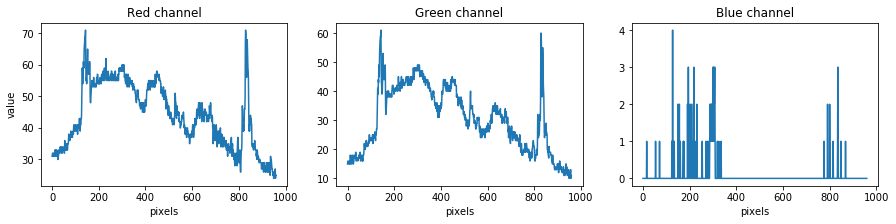

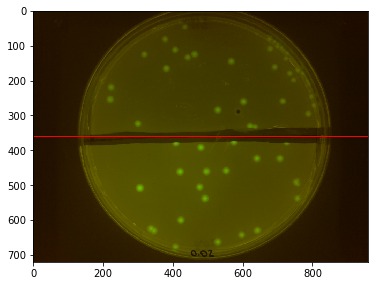

In [448]:
flup.row_transect(DataS, row=int(w/2), x_frames=Frames)

As you can see, data shows "peaks" (colonies) and a basal value along the line (background signal)

Then, to distinguish cell fluorescence from media and background light, we can select some empty sector on the image (i.e. without colonies) and compute his mean value on each frame.

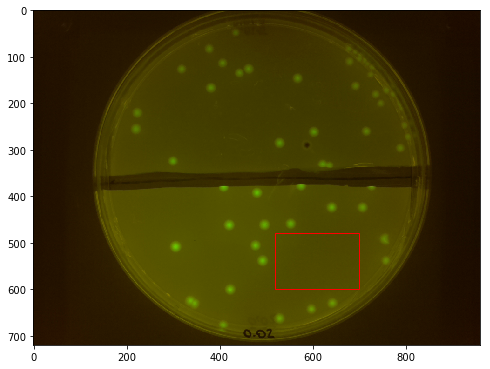

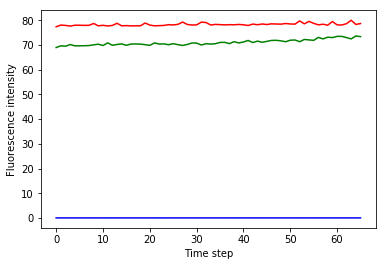

In [449]:
BG = flua.bg_value(480, 600, 520, 700, DataS, imCount)

We can substract this background value from each frame using BG_subst:

In [450]:
DataSB = flua.bg_subst(DataS,BG)

and we can check the effect on the background

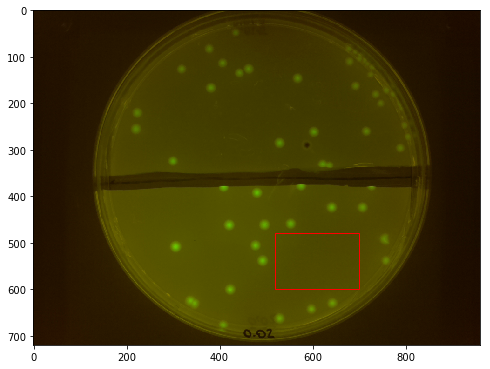

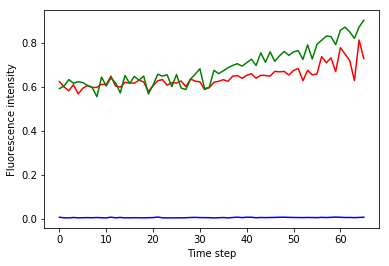

In [451]:
_ = flua.bg_value(480, 600, 520, 700, DataSB, imCount)

Background was practically eliminated.

### Get colony position
Here we are interested on identify the place where colonies are situated

A good way to do it is by sum the value of each pixel for all the channels and all the frames

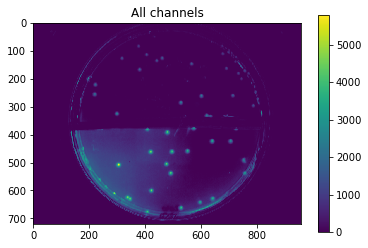

In [452]:
SumData = flua.data_sum_time(DataSB)

Now we can see each colony as a more clear point

#### Filter application
To improve the border detection and reduce the noise is recommended  to apply a filter to smooth the data. A simple and effective gaussian filter is provided by skimage package:
[skimage gaussian filter](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian)

In [453]:
from skimage.filters import gaussian

The effect of the filter can be understood with the next example:

In [454]:
#see the effect of the filter
a = np.zeros((3, 3))
a[1,1]=1
print('original: \n\n',a)
print('\nfiltered:')
gaussian(a, sigma=1)

original: 

 [[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]

filtered:


array([[ 0.05855018,  0.09653293,  0.05855018],
       [ 0.09653293,  0.15915589,  0.09653293],
       [ 0.05855018,  0.09653293,  0.05855018]])

Then we apply a the filter to the data (re-run the next line with different sigma values until you agree the smooth):

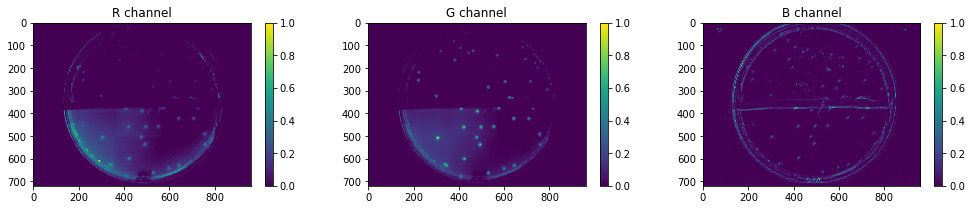

In [455]:
sDatS,sDatSall,sDatST=flua.smooth_data(DataSB,sigma=0.7)

And we can see the plot of the sumarized result

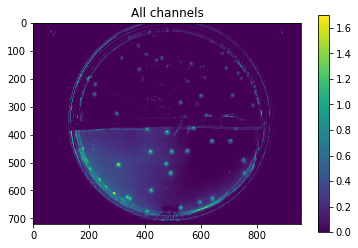

In [456]:
plt.imshow(sDatSall)
plt.colorbar()
plt.title('All channels')

#### Blob detection
Scikit-image provides several functions to detect Gaussian-like features ([blobs](http://scikit-image.org/docs/dev/auto_examples/plot_blob.html)). We apply one of these ([blob_log](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log)) to the smoothed sum of intensity, and it returns a list of position (x,y) and width (standard deviation):

To properly identification, it's important to set the threshold for each dataset manually (based on the previous colormap)

In [457]:
fname


'/Users/jonasaakenes/Dropbox/Documents/Skole/PUC/Biosyntese/Proyecto/4 Diffusion project/concentrations/0.02_0.015/img_C6_%04d.jpg'

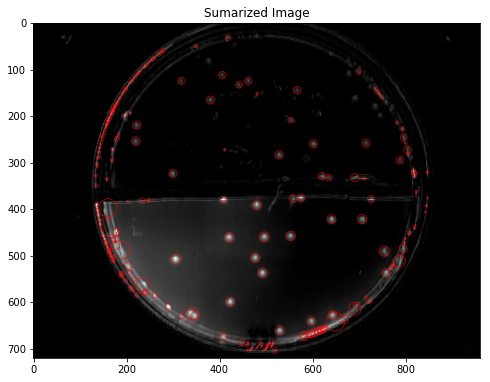

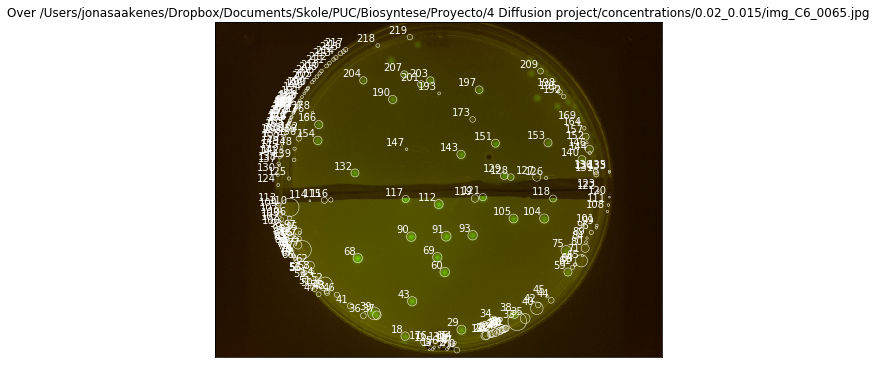

In [458]:
blobD = flua.colony_blobs_id(sDatSall,0.18,'/Users/jonasaakenes/Dropbox/Documents/Skole/PUC/Biosyntese/Proyecto/4 Diffusion project/concentrations/0.02_0.015/img_C6_0065.jpg',filename='Plots/Size_and_fluo/DetectedBlobs')

With the previous procedure we have identified where each colony is placed

To perform further analysis on each colony it is necesary to store these regions of interest (ROI) and his data, with size given by the Gaussian width (x2 = 2 standard deviations).

In [459]:
Rois,RoisC,NC = flua.obtain_rois(sDatST,blobD)

ROI x1 x2 y1 y2
0 698 711 513 526
ROI x1 x2 y1 y2
1 701 706 458 463
ROI x1 x2 y1 y2
2 699 706 495 502
ROI x1 x2 y1 y2
3 699 706 464 471
ROI x1 x2 y1 y2
4 695 702 498 505
ROI x1 x2 y1 y2
5 695 702 467 474
ROI x1 x2 y1 y2
6 695 700 479 484
ROI x1 x2 y1 y2
7 693 698 509 514
ROI x1 x2 y1 y2
8 692 699 500 507
ROI x1 x2 y1 y2
9 691 696 489 494
ROI x1 x2 y1 y2
10 689 696 510 517
ROI x1 x2 y1 y2
11 689 696 500 507
ROI x1 x2 y1 y2
12 687 696 455 464
ROI x1 x2 y1 y2
13 684 695 483 494
ROI x1 x2 y1 y2
14 685 692 512 519
ROI x1 x2 y1 y2
15 685 692 504 511
ROI x1 x2 y1 y2
16 685 690 459 464
ROI x1 x2 y1 y2
17 680 695 441 456
ROI x1 x2 y1 y2
18 665 684 399 418
ROI x1 x2 y1 y2
19 664 683 571 590
ROI x1 x2 y1 y2
20 663 682 574 593
ROI x1 x2 y1 y2
21 663 678 584 599
ROI x1 x2 y1 y2
22 662 677 587 602
ROI x1 x2 y1 y2
23 660 677 589 606
ROI x1 x2 y1 y2
24 657 676 594 613
ROI x1 x2 y1 y2
25 655 672 603 620
ROI x1 x2 y1 y2
26 654 671 605 622
ROI x1 x2 y1 y2
27 654 669 609 624
ROI x1 x2 y1 y2
28 653 668 611

ROI x1 x2 y1 y2
19 664 683 571 590
ROI x1 x2 y1 y2
20 663 682 574 593
ROI x1 x2 y1 y2
21 663 678 584 599
ROI x1 x2 y1 y2
22 662 677 587 602
ROI x1 x2 y1 y2
23 660 677 589 606
ROI x1 x2 y1 y2
24 657 676 594 613
ROI x1 x2 y1 y2
25 655 672 603 620
ROI x1 x2 y1 y2
26 654 671 605 622
ROI x1 x2 y1 y2
27 654 669 609 624
ROI x1 x2 y1 y2
28 653 668 611 626
ROI x1 x2 y1 y2
29 650 671 519 540
ROI x1 x2 y1 y2
30 652 667 613 628
ROI x1 x2 y1 y2
31 651 666 616 631
ROI x1 x2 y1 y2
32 650 665 618 633
ROI x1 x2 y1 y2
33 622 663 629 670
ROI x1 x2 y1 y2
34 631 650 589 608
ROI x1 x2 y1 y2
35 625 648 655 678
ROI x1 x2 y1 y2
36 624 637 312 325
ROI x1 x2 y1 y2
37 620 639 338 357
ROI x1 x2 y1 y2
38 618 637 634 653
ROI x1 x2 y1 y2
39 611 640 327 356
ROI x1 x2 y1 y2
40 601 628 678 705
ROI x1 x2 y1 y2
41 602 617 283 298
ROI x1 x2 y1 y2
42 601 614 688 701
ROI x1 x2 y1 y2
43 589 610 413 434
ROI x1 x2 y1 y2
44 591 604 716 729
ROI x1 x2 y1 y2
45 586 593 710 717
ROI x1 x2 y1 y2
46 579 592 255 268
ROI x1 x2 y1 y2
47 5

ROI x1 x2 y1 y2
41 602 617 283 298
ROI x1 x2 y1 y2
42 601 614 688 701
ROI x1 x2 y1 y2
43 589 610 413 434
ROI x1 x2 y1 y2
44 591 604 716 729
ROI x1 x2 y1 y2
45 586 593 710 717
ROI x1 x2 y1 y2
46 579 592 255 268
ROI x1 x2 y1 y2
47 579 590 217 228
ROI x1 x2 y1 y2
48 574 587 234 247
ROI x1 x2 y1 y2
49 573 584 234 245
ROI x1 x2 y1 y2
50 568 579 208 219
ROI x1 x2 y1 y2
51 563 574 204 215
ROI x1 x2 y1 y2
52 547 578 221 252
ROI x1 x2 y1 y2
53 549 558 194 203
ROI x1 x2 y1 y2
54 545 556 211 222
ROI x1 x2 y1 y2
55 537 548 185 196
ROI x1 x2 y1 y2
56 535 546 184 195
ROI x1 x2 y1 y2
57 533 544 183 194
ROI x1 x2 y1 y2
58 532 543 202 213
ROI x1 x2 y1 y2
59 527 546 749 768
ROI x1 x2 y1 y2
60 526 547 483 504
ROI x1 x2 y1 y2
61 521 532 763 774
ROI x1 x2 y1 y2
62 513 532 195 214
ROI x1 x2 y1 y2
63 518 525 770 777
ROI x1 x2 y1 y2
64 516 523 771 778
ROI x1 x2 y1 y2
65 499 526 774 801
ROI x1 x2 y1 y2
66 508 517 169 178
ROI x1 x2 y1 y2
67 504 513 167 176
ROI x1 x2 y1 y2
68 496 517 296 317
ROI x1 x2 y1 y2
69 4

we can ilustrate the data with the first blob (colony)

In [460]:
# show the first column of the first ROI
print(Rois['R'][0][:,1,1])
print(RoisC['R'][0][:,1,1]) #it contains only the pixels inside the circular region, and make the other equal to zero

[  1.08020630e-04   1.83600289e-02   4.78726282e-01   3.17890887e+00
   6.28045967e+00   2.14488158e+00   9.97220819e-02   6.06083518e-04
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]
[ 0.          0.          0.          0.          0.          0.
  0.09972208  0.00060608  0.          0.          0.          0.          0.        ]


The ROI let us to track every colony in a seperatelly way. The module includes a package to save an image of a selected ROI at selected times. Then is possible make timelapse grow of an indivial colony.

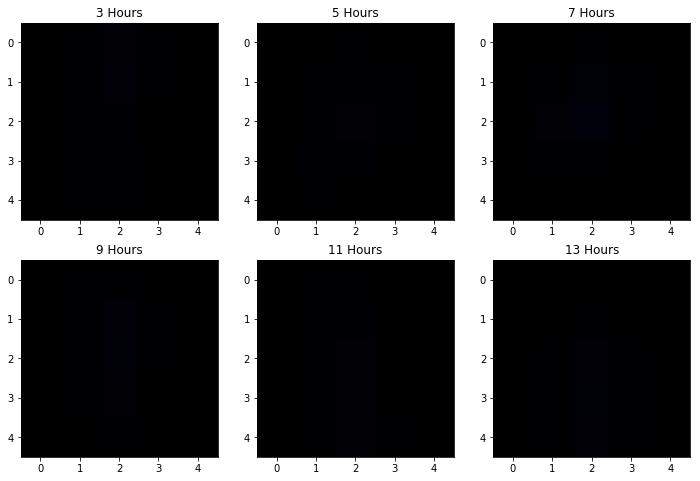

In [461]:
#Orange example
idx=120
filename=('ROIs/Col'+str(idx)+'_ROI_step%d.png')
Times=[2,4,6,8,10,12]

flup.tl_roi(Rois,idx,Times,filename,gridsize=[2,3])

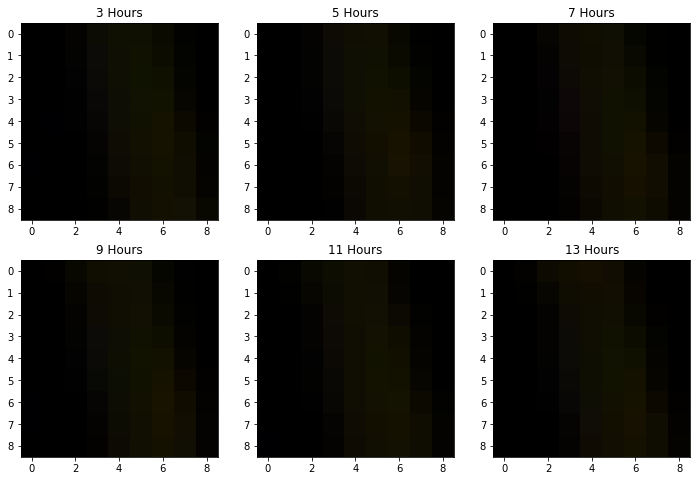

In [462]:
#Red example
idx=103
fname=('ROIs/Col'+str(idx)+'_ROI_step%d.png')
Times=[2,4,6,8,10,12]

flup.tl_roi(Rois,idx,Times,fname,gridsize=[2,3])

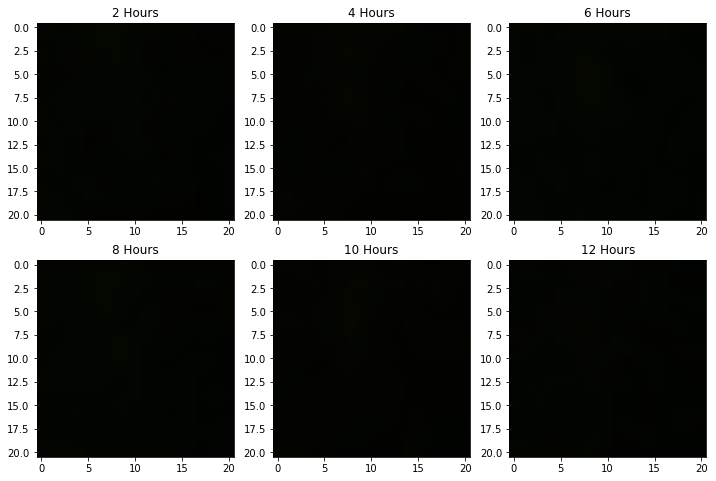

In [463]:
#Green example
idx=69
fname=('ROIs/Col'+str(idx)+'_ROI_step%d.png')
Times=[1,3,5,7,9,11]

flup.tl_roi(Rois,idx,Times,fname,gridsize=[2,3])

### Time dynamics of colonies
As we have estimated colony location (and maximmum size), we can analyse the dynamics of fluorescence and growth of them. 

#### Fluorescence dynamics
With the data obtained so far we can plot the fluorescence dynamics of colonies. We can choose some representative colonies and use the FluoPi `rois_plt_fluo_dynam()` function to perform this task:

Each line correspond to a different ROI


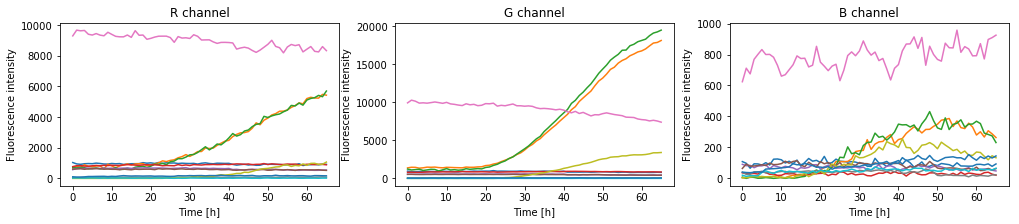

In [464]:
#define the selected colonies
Cols=[42,69,91,92,94,109,110,137,140,158,208] #upper half from 137

#use the function to plot
#flup.rois_plt_fluo_dynam(RoisC,T,Cols)
flup.rois_plt_fluo_dynam(RoisC,T,Cols,filename='Plots/Size_and_fluo/Channel_total_intensity')

print('Each line correspond to a different ROI')

#### Colony radius growth
We have the location and a final size estimate based on the total fluorescence of each colony over the time-lapse. We would like to know the size of the colony in each frame; from this we can compute the growth rate.

One way to do this is to find Gaussian blobs in each of the image regions of the colony, for each frame of the time-lapse.This is very slow

First we perform the sum of all channels for each frame to get the best representation of colony size:

In [465]:
ACRois=flua.channels_sum(RoisC,Cols) #circular ROIS

In [466]:
ACRoisS=flua.channels_sum(Rois,Cols) #square ROIS

The following loop finds blobs and stores the width in each frame. The result is a dict containing the size at each time point for every colony

In [467]:
import time
start = time.time()
R_frame=flua.frame_colony_radius(ACRoisS,Cols,0.37)
end = time.time()
print(str(end - start)+' seg') #to know how long it takes to run

39.326436042785645 seg


Since the colony is roughly circular and flat, an estimate of volume is $R^2$. Lets plot this for some colonies. Plotting the log is useful because the slope is the relative growth rate. We can see the colonies slow their growth during the experiment.

Each line correspond to one colony


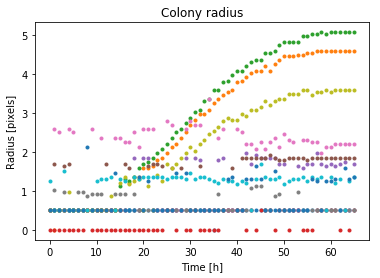

In [468]:
flup.plot_radius(R_frame, Cols, T)
print('Each line correspond to one colony')

#### Check the radius estimate
To see how well the colony size is estimated, we can compare to the profile of a colony in a slice of its image region. The radius (red line) should give the border of the colony.

/Users/jonasaakenes/Dropbox/Documents/Skole/PUC/Biosyntese/Proyecto/3 FluoPi-master/Examples/fluopi/plotting.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_dots != 'null':


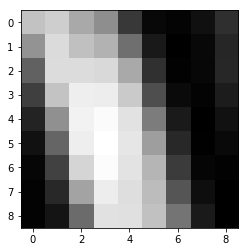

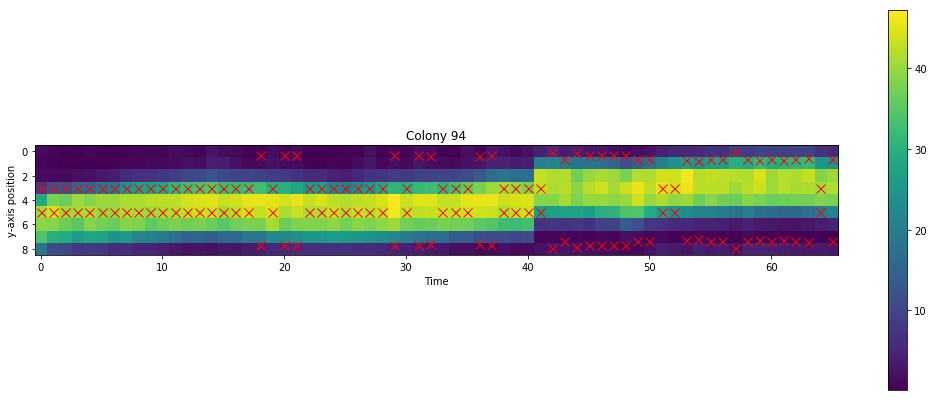

In [469]:
IDCol=Cols[4]
print()
plt.figure()
plt.imshow(ACRoisS[IDCol][:,:,-1], interpolation='none', cmap='gray')
#flup.check_radius(ACRoisS, IDCol, Times, r_dots=R_frame[IDCol])
flup.check_radius(ACRoisS, IDCol, T, r_dots=R_frame[IDCol], filename='Plots/Size_and_fluo/Kymograph_'+str(IDCol))


##### Getting the colony area over time $A(t)$
with the radius value we are able to get the colony area over time by taking it as a perfect circle: $$A(t) = \pi \cdot r^{2}$$

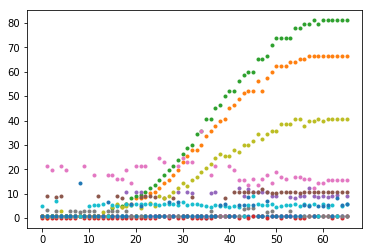

In [470]:
A=flua.area(R_frame,Cols,T)

To improve determination of radius we can fix a monotonically incresing function to the obstained values for each colony. This function could be of sigmodial type:
\begin{equation}
A(t) = \frac{a}{1+ e^{-d(t+b)}}
\end{equation}

where $a$ is the maximum area of the colony ($a = A_{max}$) and  $b$ is the time where the colony reach half of his maximum growth ($b = t_d$)

You can se the effect of the parameters evaluating the function F_logistic:

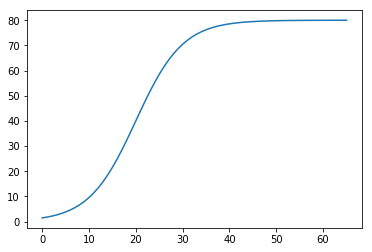

In [471]:
Sigmoid=flua.f_sigma(T, 80, -20, 0.2)
plt.plot(T,Sigmoid)

With the function `function_fit` you can fit a mathematical model (*F_sigma* by default) to one seleceted colony:

[ 11.42082057 -33.51861461   0.1       ]


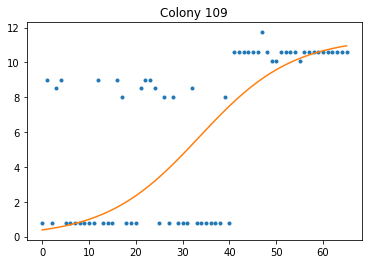

{109: (array([  0.38641502,   0.42554041,   0.46845915,   0.5155036 ,
         0.56702784,   0.6234075 ,   0.68503918,   0.75233938,
         0.8257428 ,   0.90569997,   0.99267405,   1.08713672,
         1.18956303,   1.30042518,   1.42018505,   1.54928557,
         1.68814081,   1.83712495,   1.99656019,   2.16670384,
         2.34773483,   2.53974012,   2.74270142,   2.9564828 ,
         3.18081983,   3.41531096,   3.65941174,   3.9124326 ,
         4.17354065,   4.44176587,   4.71601194,   4.99507157,
         5.27764604,   5.56236835,   5.84782915,   6.1326044 ,
         6.41528367,   6.69449793,   6.96894547,   7.23741522,
         7.49880645,   7.75214419,   7.99659032,   8.23144986,
         8.45617299,   8.67035291,   8.87372024,   9.06613443,
         9.24757304,   9.41811934,   9.57794908,   9.72731689,
         9.8665428 ,   9.99599927,  10.1160991 ,  10.22728431,
        10.33001626,  10.42476689,  10.51201127,  10.59222131,
        10.66586056,  10.73338008,  10.79521522,

In [472]:
idx=Cols[5:6] # idx have to be an array, then to select one colony use this notation Cols[desired:desired+1]
init=0
end=-1
SingleF=flua.function_fit(T,A,init,end,idx)
print(SingleF)
print(idx)

or you can perform the fit to a dictionary of selected colonies with the same function:

[ 1.  -1.   0.1]


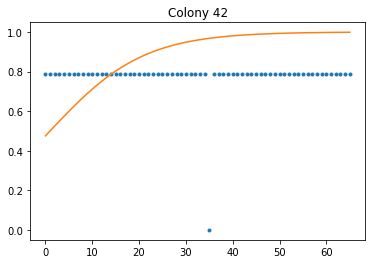

[ 68.55512419 -35.61229019   0.14182108]


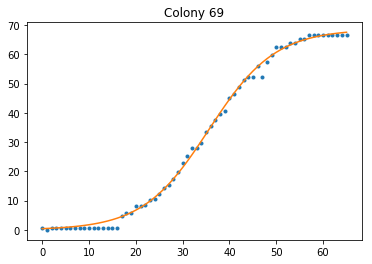

[ 84.00343365 -36.41343671   0.13171982]


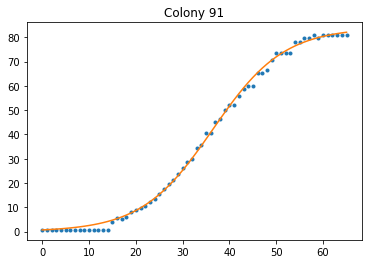

[  1.         -47.96411891   0.1       ]


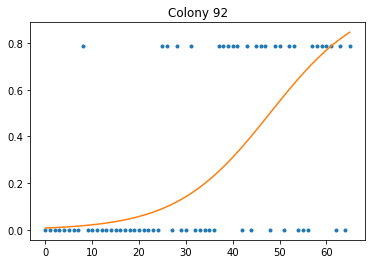

[  8.57067031 -28.81369278   0.1       ]


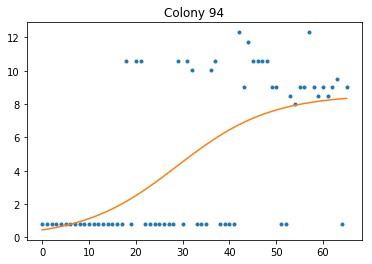

[ 11.5339619  -34.04774675   0.1       ]


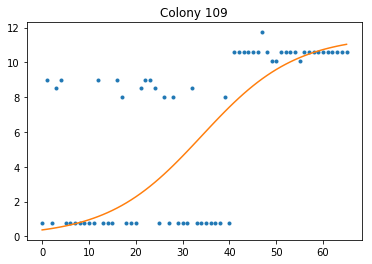

[ 15.16089627  -1.           0.11857292]


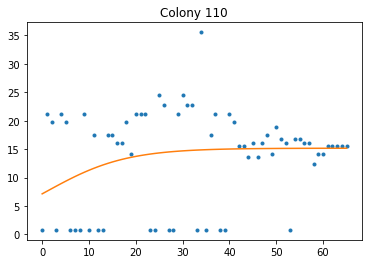

[ 1.40803989 -1.          1.        ]


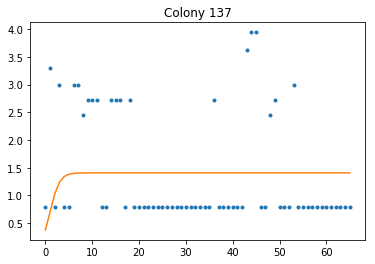

[ 42.00312581 -35.9723325    0.13564928]


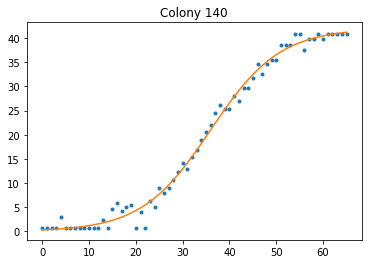

[ 5.18183845 -7.79352142  0.24138096]


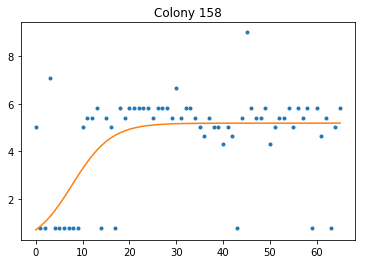

[ 2.69320956 -4.95928306  1.        ]


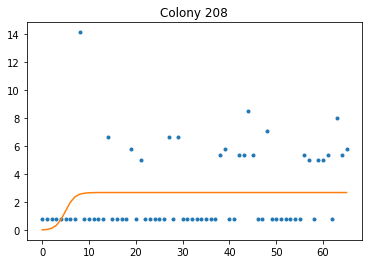

In [473]:
init=2
end=-1
A_fitS=flua.function_fit(T,A,init,end,Cols)

We can put alltogheter on one plot:

In [474]:
#set the color vector to have concordance between dots and fitted curves
colors = plt.cm.jet(np.linspace(0, 1, len(Cols))) #Paired o jet #https://matplotlib.org/users/colormaps.html


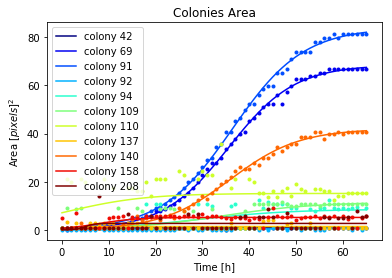

In [475]:
for i, c in zip(Cols, colors):
    plt.plot(T,A[i],'.',color=c)
    plt.plot(T,A_fitS[i][0],'-',color=c,label='colony '+str(i))

plt.xlabel('Time [h]')
plt.ylabel('Area $[pixels]^2$') 
plt.title('Colonies Area')
#plt.xlabel('Time [h]')
plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/AreaFit.pdf", transparent=True)

With the area function we are able to back-compute the radius: $$ r (t) = \sqrt{\frac{A(t)}{\pi}} $$

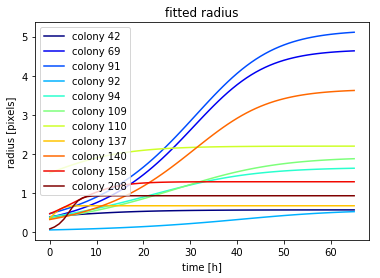

In [476]:
from math import pi
r_fit={}

plt.figure()
for i, c in zip(Cols, colors):
    r_fit[i]=(A_fitS[i][0]/pi)**(0.5)
    
    plt.plot(T,r_fit[i],'-',color=c,label='colony '+str(i))

plt.title('fitted radius')
plt.ylabel('radius [pixels]')
plt.xlabel('time [h]')
plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/colonyRadiusFit.pdf", transparent=True)

We can plot it and the blob radius together:

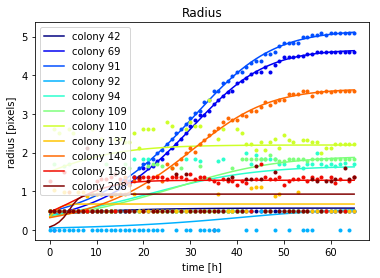

In [477]:
#fluopi.plot_radius(R_frame5,Cols,T)
for i, c in zip(Cols, colors):
    plt.plot(T,R_frame[i],'.',color=c)
    plt.plot(T,r_fit[i],'-',color=c,label='colony '+str(i))
plt.title('Radius')
plt.ylabel('radius [pixels]')
plt.xlabel('time [h]')
plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/colonyRadiusFit_points.pdf", transparent=True)

Now we can check the radius estimation again:

/Users/jonasaakenes/Dropbox/Documents/Skole/PUC/Biosyntese/Proyecto/3 FluoPi-master/Examples/fluopi/plotting.py:362: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_fit != 'null':
/Users/jonasaakenes/Dropbox/Documents/Skole/PUC/Biosyntese/Proyecto/3 FluoPi-master/Examples/fluopi/plotting.py:365: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if r_dots != 'null':


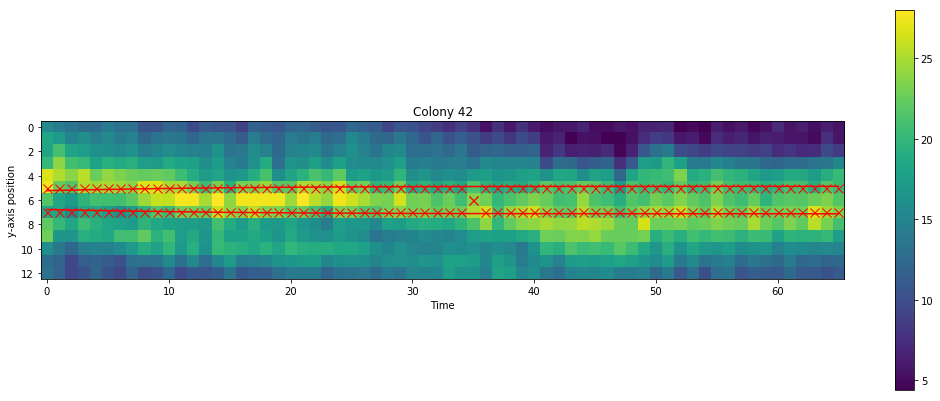

In [478]:
IDCol=int(Cols[0])
#flup.check_radius(ACRoisS,IDCol,T,r_fit=r_fit[IDCol],r_dots=R_frame[IDCol])
flup.check_radius(ACRoisS,IDCol,T,r_fit=r_fit[IDCol],r_dots=R_frame[IDCol],filename='Plots/Size_and_fluo/3Kymograph_fit2_color_'+str(IDCol))

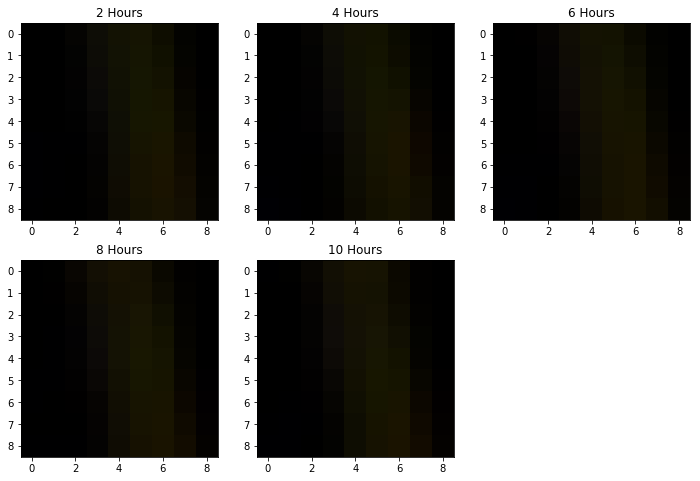

In [479]:
IDCol=Cols[5]
fname=('ROIs/sumCol'+str(IDCol)+'_ROI_step%d.pdf')
Times=[1,3,5,7,9]
flup.tl_roi(Rois,IDCol,Times,fname,radius=r_fit[IDCol], chan_sum=False, gridsize=[2,3]) 


colony grows stimation seems to get more cotinuous and improve greatly at the beginning.

### Parameter estimation from data

We now have information about sub-populations of bacteria (colonies) on the same plate. The fluorescence in each region of interest estimates the time varying fluorescent protein level in each colony. The radius (or $R^2$) approximates the size of each sub-population (colony) and so is similar to optical density (OD) in a bulk plate-reader experiment. 

Lets write a simple model of fluorescent protein expression from a single cell:

\begin{equation}
\frac{dF}{dt} = k(t) - (\mu(t) + \delta(t))F
\end{equation}

where $F$ is the cell's fluorescent protein concentration, which is produced at time-varying rate $k(t)$. The cell grows at relative rate $\mu(t)=(1/V)dV/dt$ ($V=$volume) causing dilution, but assuming a constant thickness of the colony it becomes proportional to the area: $\mu(t)=(1/A)dA/dt$ ($A=$area). 
The protein is degraded at rate $\delta(t)$.


For the proteins we are using we will assume that $\delta(t)=0$ for all times. We measure the total fluorescence intensity, which is the concentration $F$ multiplied by the total volume of the colony $A_{tot} = \pi R^2$. Hence,

\begin{equation}
I(t) = F(t)A(t) \approx F(t) \pi R^2(t)
\end{equation}

From these equations it is possible to derive (see [maths](https://github.com/SynBioUC/FluoPi/blob/5533704f41cf62f56551a40159e8ebd785a2b66b/Maths/Fluorescence%2Bmaths.pdf)) the fluorescent expresion rate constant could be represented by: $$ K_f = \frac{d(I/A)}{dt} + \mu \cdot (I/A) $$


To be able to estimate the value of this parameter we have to compute the values of each element in his representative equation.

To get an acurate analysis of the gener expression dynamics of the colonies, the module include a function to compute the average fluorescent value inside the limits of the colony (defined by the radius fitting) on each time. This average value correspond to $I/A$ (see the [maths](https://github.com/SynBioUC/FluoPi/blob/5533704f41cf62f56551a40159e8ebd785a2b66b/Maths/Fluorescence%2Bmaths.pdf))

In [480]:
MeanInt=flua.croi_mean_int_frames(sDatST,blobD,r_fit,Cols)

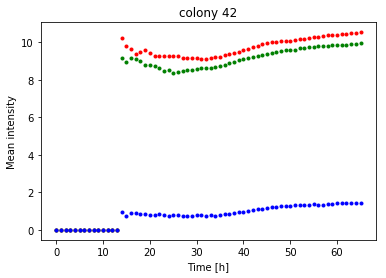

In [481]:
idx=Cols[0]
plt.plot(T,MeanInt['R'][idx],'.',color='r')
plt.plot(T,MeanInt['G'][idx],'.',color='g')
plt.plot(T,MeanInt['B'][idx],'.',color='b')
plt.ylabel('Mean intensity')
plt.xlabel('Time [h]')
plt.title('colony '+str(idx))

by sum the three channels we can get the total intensity per area $(I/A)_{total}$

In [482]:
#let's sum the three channels
MeanInt3C={}
for i in Cols:
    Vaux=np.zeros((MeanInt['R'][i].shape))
    for c in channels:
        Vaux+=MeanInt[c][i]
    
    MeanInt3C[i]= Vaux

this plot contain the sum of the mean of the three channels over time for each colony


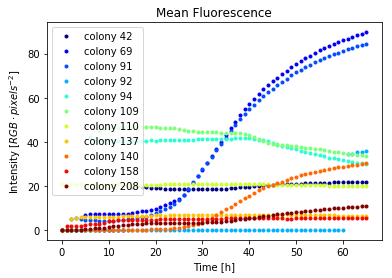

In [483]:
plt.figure()
for i, c in zip(Cols, colors):
    plt.plot(T,MeanInt3C[i],'.',color=c,label='colony '+str(i))

plt.title('Mean Fluorescence')
plt.xlabel('Time [h]')
plt.ylabel('Intensity $[RGB \cdot pixels^{-2}]$')
plt.legend(loc='upper left')
    
plt.savefig("Plots/Size_and_fluo/MeanInt.pdf", transparent=True)

print('this plot contain the sum of the mean of the three channels over time for each colony')

With that is possible to compute the derivative of this value: $ d(I/A)/dt $

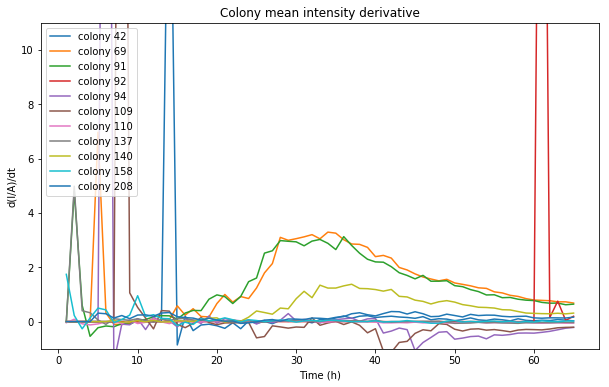

In [484]:
dIAdt_dis={}
plt.figure(figsize=(10,6))
for i in Cols:
    #delta_MeanInt3C is the intensity divided by the area = d(I/A)/dt
    delta_MeanInt3C = np.diff(MeanInt3C[i])
    delta_T=np.diff(T)
    dIAdt_dis[i] = delta_MeanInt3C/delta_T
    plt.plot(T[1:],dIAdt_dis[i],'-',label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel('d(I/A)/dt')
    plt.ylim([-1,11])
    plt.legend(loc='upper left')
    plt.title('Colony mean intensity derivative')

Finally, we should compute the $\mu(t)=(1/A)dA/dt$
, which under the sigmoideal growth moldel it's equal to: $$\mu = \frac{d}{e^{d \cdot (t+b)}+1} $$

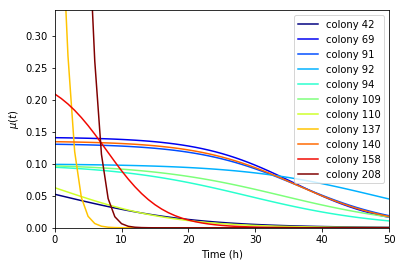

In [485]:
Mu_val={}
for i, c in zip(Cols, colors):
    Mu_val[i]=flua.f_mu(T,A_fitS[i][1][1],A_fitS[i][1][2])
    plt.plot(T,Mu_val[i],'-',color=c,label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel(r'$\mu (t)$')
    plt.xlim([0,50])
    plt.ylim([0,0.34])
    plt.legend(loc='upper right')
plt.savefig("Plots/Size_and_fluo/GrowthRate.pdf", transparent=True)


## Data smoothing

To perform an accurated estimation it's good to apply data smoothing.

In [486]:
from scipy.interpolate import UnivariateSpline

[Univariate Spline Documentation](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.interpolate.UnivariateSpline.html)

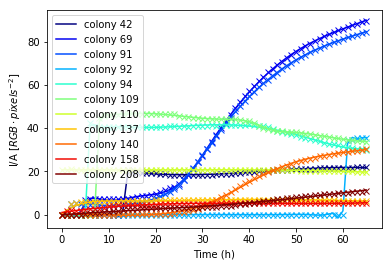

In [487]:
IA_smooth={}

for i, c in zip(Cols, colors):
    IA_smooth[i] = UnivariateSpline(T,MeanInt3C[i], k=3)   # k is the degree of the smoothing spline  (<=5)
    IA_smooth[i].set_smoothing_factor(10)
    plt.plot(T,IA_smooth[i](T[:]),'-',color=c, label='colony '+str(i))
    plt.plot(T,MeanInt3C[i],'x',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('I/A $[RGB \cdot pixels^{-2}]$')
    plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
plt.savefig("Plots/Size_and_fluo/IA_smooth.pdf", transparent=True)

From this smooth values of _IA_ we can compute his derivative:

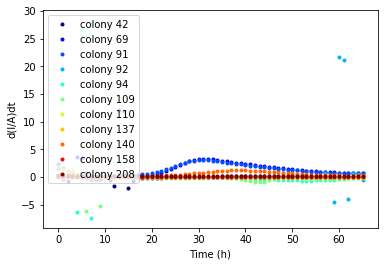

In [488]:
dIAdt={}
for i, c in zip(Cols, colors):
    dIAdt[i]=IA_smooth[i].derivative()   # k is the degree of the smoothing spline  (<=5)
    #dIAdt_smooth[i].set_smoothing_factor(55)
    plt.plot(T,dIAdt[i](T),'.',color=c, label='colony '+str(i))
plt.xlabel('Time (h)')
plt.ylabel('d(I/A)dt')
plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
plt.savefig("Plots/Size_and_fluo/d(IA)dt.pdf", transparent=True)

Or we can make the smooth of the previuos *dIAdt_dis* computed values:

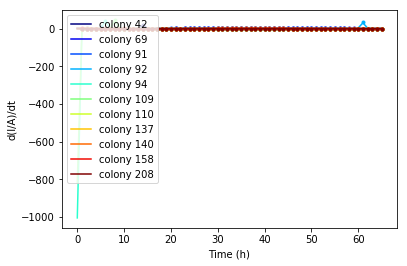

In [489]:
dIAdt_smooth={}

for i, c in zip(Cols, colors):
    dIAdt_smooth[i] = UnivariateSpline(T[1:],dIAdt_dis[i], k=4)   # k is the degree of the smoothing spline  (<=5)
    #dIAdt_smooth[i].set_smoothing_factor(55)
    plt.plot(T[:],dIAdt_smooth[i](T[:]),'-',color=c, label='colony '+str(i))
    plt.plot(T[1:],dIAdt_dis[i],'.',color=c)
    plt.xlabel('Time (h)')
    plt.ylabel('d(I/A)/dt')
    plt.legend(loc='upper left')
    #plt.ylim([-5,20])
    
plt.savefig("Plots/Size_and_fluo/d(IA)dT_smooth.pdf", transparent=True)
    

Finally, the fluorescent expresion rate constant could be represented by: $$ K_f = \frac{d(I/A)}{dt} + \mu \cdot (I/A) $$

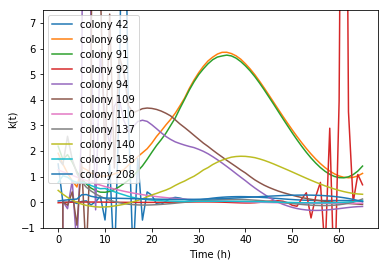

In [490]:
Kf={}
for i, c in zip(Cols, colors):
    Kf[i]=dIAdt_smooth[i](T[:])+Mu_val[i]*MeanInt3C[i]
    plt.plot(T[:],Kf[i],'-',label='colony '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel('k(t)')
    plt.ylim([-1,7.5])
    plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/K_dynamics.pdf", transparent=True)

# Project without diffusion

Then we want to find the maximum synthesis rate of each of the colonies, which are approxemately on the same time.

Concentration 0.020:  6.81917177888
Concentration 0.015:  0.959557492294


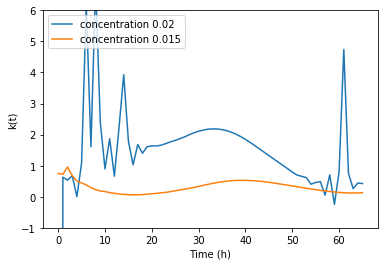

In [491]:
Maxs=[1,2,3,4]   #Number of concetrations
Cons=[0.02,0.015]
n=137            #first colony of the upper half
Kfa={}
for i in Cons:
    Kfa[i]=0;

lower=0;
upper=0;
k=0;
for i in Cols:
    if i == n:    
        k+=1;
        lower=upper;
        upper=0;
    Kfa[Cons[k]]+=Kf[i]
    upper+=1
Kfa[Cons[0]]=Kfa[Cons[0]]/lower
Kfa[Cons[1]]=Kfa[Cons[1]]/upper

for i, c in zip(Cons, colors):
    plt.plot(T[:],Kfa[i],'-',label='concentration '+str(i))
    plt.xlabel('Time (h)')
    plt.ylabel('k(t)')
    plt.ylim([-1,6])
    plt.legend(loc='upper left')
plt.savefig("Plots/Size_and_fluo/K_dynamics.pdf", transparent=True)

print('Concentration 0.020: ',max(Kfa[0.02]))    
print('Concentration 0.015: ',max(Kfa[0.015]))

Were doing the same again, but with error bars, so the lower one is better

In [492]:
def mk_graphic( Cols, T):
    mk=np.zeros((upper,len(T)))    #lower or upper after which half you look at
    k=0
    t=0
    for i in Cols:
#        if i==n:                   #choose if you want to see the upper half or the lower half by commenting this if
#            break
        if i<n:
            continue
        while t<len(T):
            mk[k,int(t)]= Kf[int(i)][int(t)]
            t+=1
        k+=1
        t=0
    mk_stdlow=np.std(mk[0:(lower-1)], 0)
    mk_meanlow=np.mean(mk[0:(lower-1)],0)
    l=mk_meanlow+2*mk_stdlow
    print("Maximum average k-value: ",max(mk_meanlow))
    
#    mk_stdupp=np.std(mk[lower:(upper-1)], 0)
#    mk_meanupp=np.mean(mk[lower:(upper-1)],0)
#    l=mk_meanupp+2*mk_stdupp
    
    fig, ax = plt.subplots()
    ax.errorbar(T, mk_meanlow, yerr=mk_stdlow)

#    fig, ax1 = plt.subplots()
#    ax1.errorbar(T, mk_meanupp, yerr=mk_stdupp)
    
    plt.xlabel("Time(h)")
    plt.ylabel("mean k(t) ")
    plt.show()
    return l

def mk_mean( columnas, tiempos):
    mk=np.zeros((len(Cols),len(T)))
    k=0
    t=0
    for i in Cols:
        while t<len(T):
            mk[k,int(t)]= Kf[int(i)][int(t)]
            t+=1
        k+=1
    mk_std=np.std(mk, 0)
    mk_mean=np.mean(mk,0)
    return (mk_mean,mk_std)

Maximum average k-value:  0.959557492294


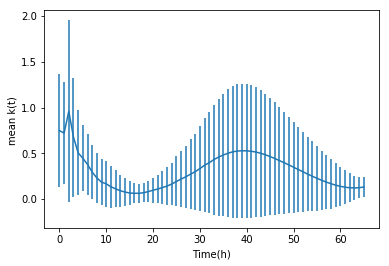

In [493]:
l=mk_graphic(Cols,T)
(a,b)=mk_mean(Cols,T)
#print(a,'\n',b)

The difference between these colonies is just the concentrationes, so we could plot the concentration versus the maximum rate of synthesis. This will hopefully look something like this:
![Rate of synthesis against concentration][1]
[1]:https://i.imgur.com/dDOSfP9.jpg

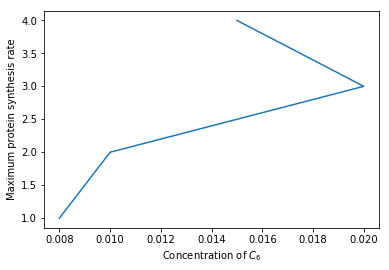

In [494]:
Cons=[0.008,0.01,0.02,0.015] #Need to specify number of results
plt.plot(Cons,Maxs,'-')
plt.xlabel('Concentration of $C_6$')
plt.ylabel('Maximum protein synthesis rate')

Depending on the model we are using, we would either approximate this as a step fuction or a simple model for the synthesis rate:

$$ F_p = (F_{max} - F_{min})\frac{K[C_6]^2}{1+K[C_6]^2}+F_{min}$$

The difference is shown in the red (simple) and green (step function) line in the graphics:

![Approximations of K][1]
[1]:https://i.imgur.com/Lnm9GOu.jpg

For the two cases we need to curvefit to find the parameters we are looking for:

F_Max =  4.09221429234 
F_Min =  -11333.1354769 
K =  57965784.1604 

1/2 (F_Max - F_Min) =  -5664.52163129


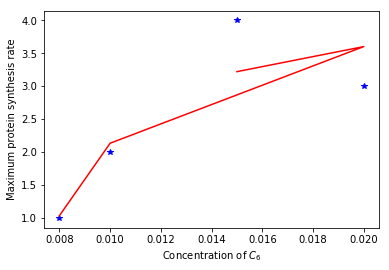

In [495]:
def simple(x, K, Fmax, Fmin):
    return ((Fmax-Fmin)*K*np.square(x)/(1+K*np.square(x))+Fmin)

Cons2=np.array(Cons)
Maxs2=np.array(Maxs)
plt.plot(Cons2, Maxs2, 'b*', label='data')

popt,pcov = curve_fit(simple,Cons2,Maxs2,p0=[1,1,1])
plt.plot(Cons2, simple(Cons2, *popt), 'r-')
plt.xlabel('Concentration of $C_6$')
plt.ylabel('Maximum protein synthesis rate')

print('F_Max = ',popt[1],"\nF_Min = ",popt[2],"\nK = ",popt[0],"\n\n1/2 (F_Max - F_Min) = ",(popt[1]+popt[2])/2)

This relationship will be quite useful for the next test.

# Project with diffusion

For the test with diffusion: We also want to take the avegage between the three colonies that are in the same distance from the diffusion source. I assume here that all colonies are picked in the right order, so each simular colony are next to each other in pairs of three.
![Pairing colonies][1]
[1]: https://i.imgur.com/0C8FrMb.jpg

In [496]:
Kfd={}
k=0;
for i, c in zip(Cols, colors):
    Kfd[k]=dIAdt_smooth[i](T[:])+Mu_val[i]*MeanInt3C[i]
    k=k+1;
Kfda={}
r=0;
a=0;
while a < len(Kfd):
    Kfda[r]=(Kfd[a]+Kfd[a+1]+Kfd[a+2])/3
    a=a+3;
    r=r+1;
    
for b in Kfda:
    plt.plot(T[:],Kfda[b],'-',label='colony '+str(b))
    plt.xlabel('Time (h)')
    plt.ylabel('k(t)')
    plt.ylim([-1,5])
    plt.legend(loc='upper left')

for k in Kfd:
    plt.savefig("Plots/Size_and_fluo/K_dynamics_avergae_diffusion.pdf", transparent=True)

KeyError: 11

Then I am picking out each of the top points, and look what that valvue represents in the plot between synthesis rate maximum and $C_6$ concentration. I am basically assuming that at the pont of maximum synthesis rate for each distance, it will have the same concentration of $C_6$ as for the same level of synthesis rate without diffusion.
![Synthesis rate without vs with diffusion][1]
[1]:https://i.imgur.com/RIHkZ5i.jpg

Meaning that in the skect, the concentratoin of the colonies at distance $x_1$ would be $c_1$ at the time $t_1$, and so on. We would need to calculate the $K([C_6])$ from the results of the test without diffusion.

$$ C^2(K) = \frac{\frac{F_p - F_{min}}{F_{max}-F_{min}}}{K\left(1-\frac{F_p - F_{min}}{F_{max}-F_{min}}\right)}$$

Then we only know *one* concentration at *one* time for each of the distances. By using Ficks law of diffusion:

$$ c(x,t) = \frac{1}{\sqrt{4\pi kt}} exp\left(-\frac{x^2}{4kt}\right)$$

we could calculate a diffusion constant for each pair of $(t_a, x_a, c_a)$, and hopefully those are about the same. We cant solve the diffusion equation directly for k, so we will do a numerical interpolation, trough:

$$ k = \frac{1}{4\pi c^2}exp\left(-\frac{x^2}{2kt}\right) $$


In [ ]:
def simple_rev(Fp,K,Fmax,Fmin): #reverse of the simple model
    return (math.sqrt(((Fp-Fmin)/(Fmax-Fmin))/(K*(1-((Fp-Fmin)/(Fmax-Fmin))))))

def diffusion(time,dist,cons):
    dk=1;
    k=1;
    while abs(dk) > 0.000001:
        dk = k
        k = 1/(4*math.pi*cons**2)*math.exp(-(dist**2)/2*k*time)
        dk = dk-k
    return k

Dist=[1,2,3,4]   #Need to specify
Times=[1,2,3,4]  #Need to specify number of results
Maxsd=[1,2,3,4]  #Need to specify number of results

for i in Kfda:
    Maxsd[i]=max(Kfda[i])
    Times[i]=Kfda[i].argmax(axis=0)

Consd=[1,2,3,4];
k=0;
for i in Kfda:
    Consd[i]=simple_rev(Maxsd[i],*popt)
    k=diffusion(Times[i],Dist[i],Cons[i])
    print("Pair of (t,x,c):  (",Times[i],",",Dist[i],",",Consd[i],")   ->   k =",k)

Well look at that!